In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pandas as pd
import random
from shutil import copyfile

from utils.gan_utils import StarGANGenerator, Pix2PixGenerator, CycleGANGenerator
from utils.search_utils import AkiwiFeatureGenerator, ResnetFeatureGenerator, Search, CombinedSearch

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
StarGAN = StarGANGenerator('./models/stargan/')

Couldn't find model ./models/stargan/pattern.pth


In [3]:
CycleGAN = CycleGANGenerator('./models/cyclegan/best/')

In [4]:
Pix2Pix = Pix2PixGenerator('./models/pix2pix_models.pth')

In [5]:
def plot_img_row(images, img_labels=None):
    fig, axarr = plt.subplots(nrows=1, ncols=len(images), figsize=(len(images)*3, 4))
    
    for i, img in enumerate(images):
        ax = axarr[i]
        img = img.crop((40, 0, 216, 256))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.keys():
            ax.spines[spine].set_visible(False)
        
        if img_labels is not None:
            ax.set_title(img_labels[i])
        
    plt.show()

# Load Search Models

In [6]:
folder_gens = {'akiwi_50': AkiwiFeatureGenerator(50), 
               'akiwi_64': AkiwiFeatureGenerator(64),
               'akiwi_114': AkiwiFeatureGenerator(114),
               'resnet': ResnetFeatureGenerator(),
               'resnet_retrained': ResnetFeatureGenerator('./models/resnet152_retrained.pth')
              }

In [7]:
dress_imgs = '../../data/fashion/dresses/'
model_imgs = '../../data/fashion_models/dresses_clustered2/'

dress_feats = './data/features/fashion/dresses/'
model_feats = './data/features/fashion_models/dresses/'

In [8]:
dress_search = {}
for dir_name, gen in folder_gens.items():
    dress_search[dir_name] = Search(dress_imgs, os.path.join(dress_feats, dir_name), gen)

Loading features from: ./data/features/fashion/dresses/akiwi_50
Loading features from: ./data/features/fashion/dresses/akiwi_64
Loading features from: ./data/features/fashion/dresses/akiwi_114
Loading features from: ./data/features/fashion/dresses/resnet
Loading features from: ./data/features/fashion/dresses/resnet_retrained


In [9]:
model_search = {}
for dir_name, gen in folder_gens.items():
    model_search[dir_name] = Search(model_imgs, os.path.join(model_feats, dir_name), gen)

Loading features from: ./data/features/fashion_models/dresses/akiwi_50
Loading features from: ./data/features/fashion_models/dresses/akiwi_64
Loading features from: ./data/features/fashion_models/dresses/akiwi_114
Loading features from: ./data/features/fashion_models/dresses/resnet
Loading features from: ./data/features/fashion_models/dresses/resnet_retrained


In [47]:
# combined search
dress_search['resnet_50'] = CombinedSearch([dress_search['akiwi_50'], dress_search['resnet']], factors=[2, 1])
model_search['resnet_50'] = CombinedSearch([model_search['akiwi_50'], model_search['resnet']], factors=[2, 1])

# Shape modification

In [11]:
def get_stargan_imgs_for_attr(img, attr):
    
    fake_imgs = []
    values = StarGAN.LABELS[attr]
    for idx, v in enumerate(values):
        
        fake_img = StarGAN.generate_image(img, attr, v)
        fake_imgs.append(fake_img)
    return fake_imgs

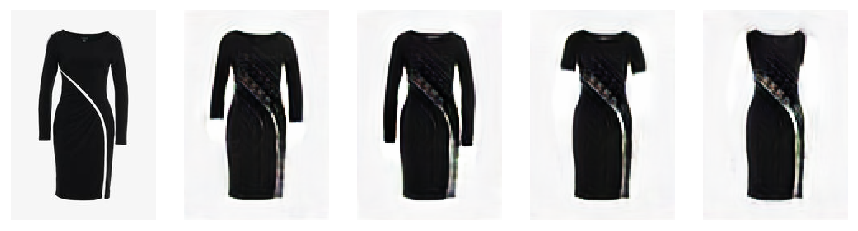

In [12]:
img_path = '../../data/fashion/dresses/L4221C0HY-Q11.jpg'
sleeve_imgs = get_stargan_imgs_for_attr(Image.open(img_path), 'sleeve_length')
sleeve_imgs = [Image.open(img_path)] + sleeve_imgs
plot_img_row(sleeve_imgs)

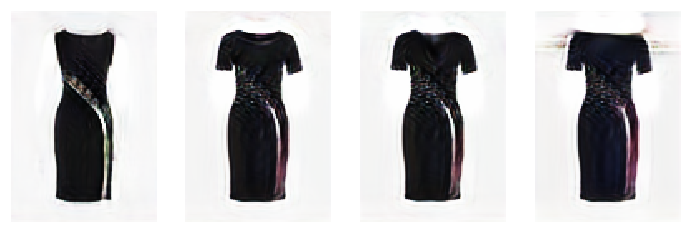

In [13]:
neck_imgs = get_stargan_imgs_for_attr(sleeve_imgs[-2], 'neckline')
neck_imgs = [sleeve_imgs[-1]] + neck_imgs
plot_img_row(neck_imgs)

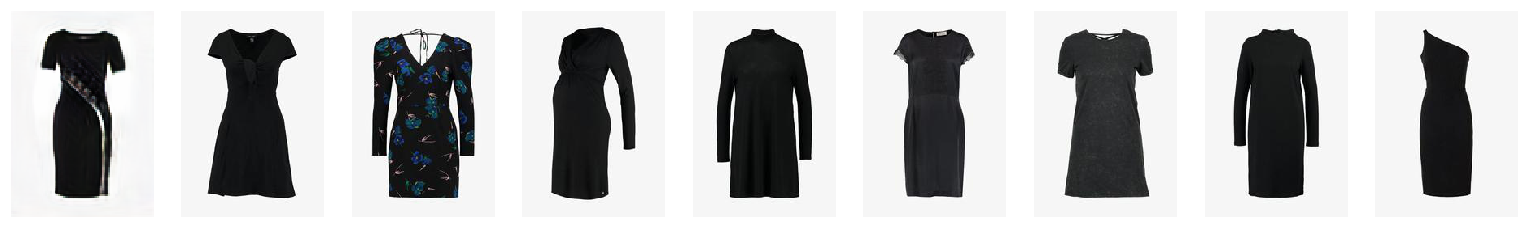

In [14]:
s = dress_search['resnet']
sim_imgs = s.get_similar_images(sleeve_imgs[-2])
plot_img_row([sleeve_imgs[-2]] + [Image.open(i) for i in sim_imgs])

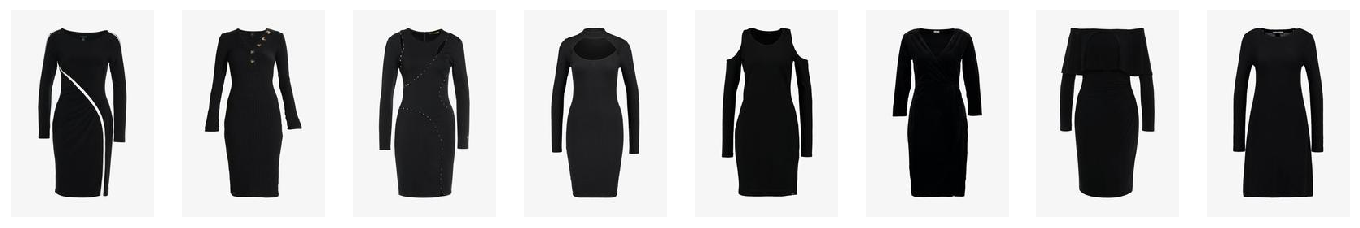

In [15]:
s = dress_search['resnet']
sim_imgs = s.get_similar_images(Image.open(img_path))
plot_img_row([Image.open(i) for i in sim_imgs])

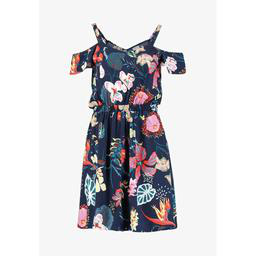

In [50]:
test_img = '../../data/fashion/dresses/V1021C12K-K11.jpg'
Image.open(test_img)

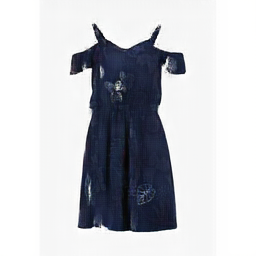

In [53]:
no_pattern = CycleGAN.generate_image(Image.open(test_img), 'floral', 'from')
no_pattern

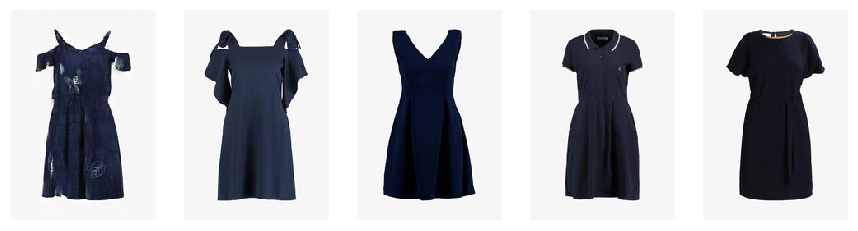

In [54]:
s = dress_search['resnet_50']
sim_imgs = s.get_similar_images(no_pattern, num_imgs=4, metric='l1')
plot_img_row([no_pattern] + [Image.open(i) for i in sim_imgs])

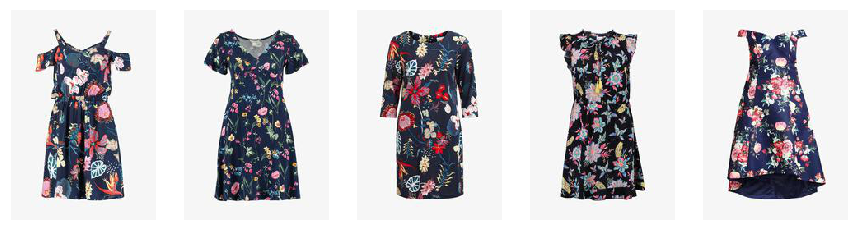

In [55]:
s = dress_search['resnet_50']
sim_imgs = s.get_similar_images(Image.open(test_img), num_imgs=5, metric='l1')
plot_img_row([Image.open(i) for i in sim_imgs])

# Model Image

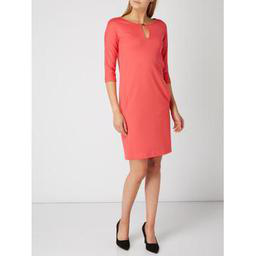

In [56]:
test_img = '../../data/fashion/dresses/9821539.jpg'
model_img = '../../data/fashion_models/dresses_clustered2/9821539.jpg'
Image.open(model_img)

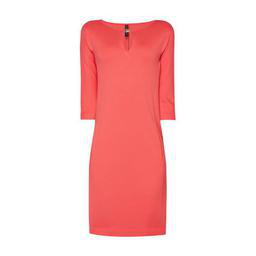

In [57]:
Image.open(test_img)

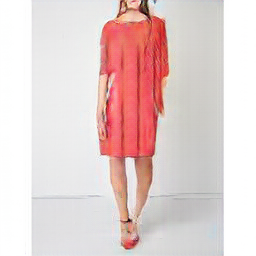

In [58]:
fake_img = Pix2Pix.generate_image(Image.open(test_img))
fake_img

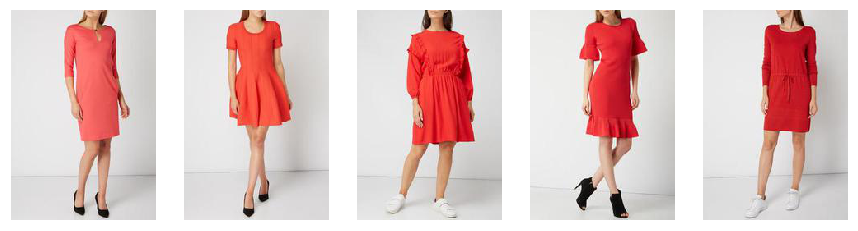

In [59]:
s = model_search['resnet_50']
sim_imgs = s.get_similar_images(Image.open(model_img), num_imgs=5)
plot_img_row([Image.open(i) for i in sim_imgs])

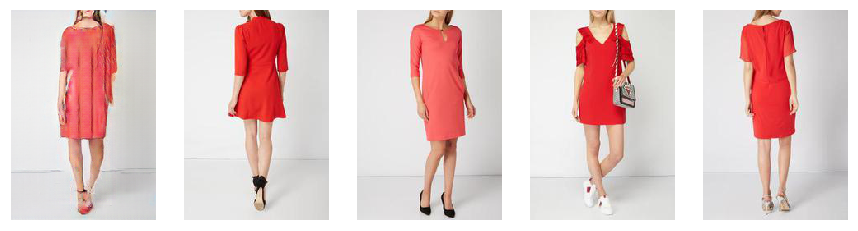

In [60]:
s = model_search['resnet_50']
sim_imgs = s.get_similar_images(fake_img, num_imgs=4)
plot_img_row([fake_img] + [Image.open(i) for i in sim_imgs])

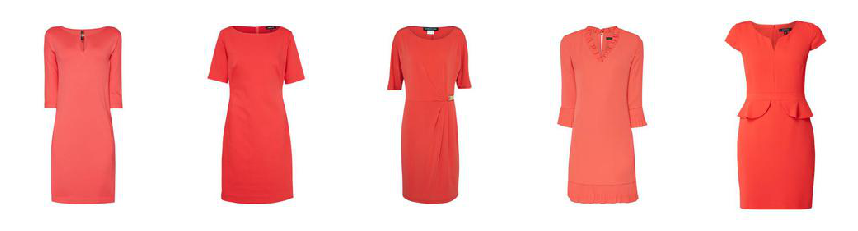

In [44]:
s = dress_search['resnet_50']
sim_imgs = s.get_similar_images(Image.open(test_img), num_imgs=5)
plot_img_row([Image.open(i) for i in sim_imgs])